## 3. InceptionV3 Fine Tune
### Result:
- Kaggle score:1.41862

### References:
1. https://github.com/ypwhs/dogs_vs_cats
2. https://www.kaggle.com/yangpeiwen/keras-inception-xception-0-47

### Import pkgs

In [1]:
import cv2
import numpy as np
from tqdm import tqdm
import pandas as pd
import os, time
import random
import matplotlib.pyplot as plt
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


In [2]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, TensorBoard

from keras.applications.inception_v3 import InceptionV3, preprocess_input

### Run name

In [3]:
project_name = 'Dog_Breed_Identification'
step_name = 'InceptionV3FineTune'
date_str = time.strftime("%Y%m%d", time.localtime())
time_str = time.strftime("%Y%m%d_%H%M%S", time.localtime())
run_name = project_name + '_' + step_name + '_' + time_str
print('run_name: ' + run_name)

run_name: Dog_Breed_Identification_InceptionV3FineTune_20171102_104830


### Basic folders

In [4]:
cwd = os.getcwd()
input_path = os.path.join(cwd, 'input')
log_path = os.path.join(cwd, 'log')
model_path = os.path.join(cwd, 'model')
output_path = os.path.join(cwd, 'output')
print('input_path: ' + input_path)
print('log_path: ' + log_path)
print('model_path: ' + model_path)
print('output_path: ' + output_path)

input_path: E:\Udacity\MachineLearning(Advanced)\p6_graduation_project\input
log_path: E:\Udacity\MachineLearning(Advanced)\p6_graduation_project\log
model_path: E:\Udacity\MachineLearning(Advanced)\p6_graduation_project\model
output_path: E:\Udacity\MachineLearning(Advanced)\p6_graduation_project\output


### Load data

In [5]:
cwd = os.getcwd()
df = pd.read_csv(os.path.join(cwd, 'input', 'labels.csv'))
print('lables amount: %d' %len(df))
df.head()

lables amount: 10222


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [6]:
n = len(df)
breed = set(df['breed'])
n_class = len(breed)
breed = sorted(breed)
print(breed)
class_to_num = dict(zip(breed, range(n_class)))
num_to_class = dict(zip(range(n_class), breed))

['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale', 'american_staffordshire_terrier', 'appenzeller', 'australian_terrier', 'basenji', 'basset', 'beagle', 'bedlington_terrier', 'bernese_mountain_dog', 'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound', 'bluetick', 'border_collie', 'border_terrier', 'borzoi', 'boston_bull', 'bouvier_des_flandres', 'boxer', 'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff', 'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua', 'chow', 'clumber', 'cocker_spaniel', 'collie', 'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo', 'doberman', 'english_foxhound', 'english_setter', 'english_springer', 'entlebucher', 'eskimo_dog', 'flat-coated_retriever', 'french_bulldog', 'german_shepherd', 'german_short-haired_pointer', 'giant_schnauzer', 'golden_retriever', 'gordon_setter', 'great_dane', 'great_pyrenees', 'greater_swiss_mountain_dog', 'groenendael', 'ibizan_hound', 'irish_setter', 'irish_terrier', 'iris

In [7]:
width = 299
X = np.zeros((n, width, width, 3), dtype=np.uint8)
y = np.zeros(n, dtype=np.uint8)
for i in tqdm(range(n)):
    X[i] = cv2.resize(cv2.imread('.\\input\\train\\%s.jpg' % df['id'][i]), (width, width))
    y[i] = class_to_num[df['breed'][i]]

100%|███████████████████████████████████| 10222/10222 [00:59<00:00, 170.37it/s]


### Preview images

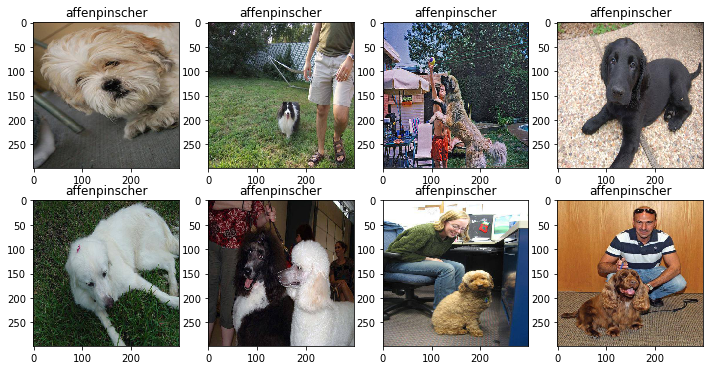

In [8]:
plt.figure(figsize=(12, 6))
for i in range(8):
    random_index = random.randint(0, n-1)
    plt.subplot(2, 4, i+1)
    plt.imshow(X[random_index][:,:,::-1])
    plt.title(num_to_class[y[random_index].argmax()])
plt.show()

## Shulfe and split data

In [9]:
print(X.shape)
print(y.shape)
# x_data = X.reshape(X.shape[0],-1)
x_data = X
print(y[0:10])
y_data = to_categorical(y)
print(x_data.shape)
print(y_data.shape)

(10222, 299, 299, 3)
(10222,)
[19 37 85 15 49 10 10 18  7 97]
(10222, 299, 299, 3)
(10222, 120)


In [10]:
from sklearn.utils import shuffle
x_data, y_data = shuffle(x_data, y_data)

In [11]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.05)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(9710, 299, 299, 3)
(9710, 120)
(512, 299, 299, 3)
(512, 120)


### Build method

In [12]:
def build_model():
    # create the base pre-trained model
    base_model = InceptionV3(weights='imagenet', include_top=False)

    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # let's add a fully-connected layer
    x = Dense(2048, activation='relu')(x)
    x = Dense(2048, activation='relu')(x)
    # and a logistic layer -- let's say we have 200 classes
    predictions = Dense(120, activation='softmax')(x)

    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)

    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all convolutional InceptionV3 layers
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer = Adam(lr=1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model

In [13]:
model = build_model()
# model.summary()

In [14]:
def saveModel(model, run_name):
    cwd = os.getcwd()
    modelPath = os.path.join(cwd, 'model')
    if not os.path.isdir(modelPath):
        os.mkdir(modelPath)
    weigthsFile = os.path.join(modelPath, run_name + '.h5')
    model.save(weigthsFile)
# saveModel(model, 'saveModel_test')

In [15]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

log_dir = os.path.join(log_path, run_name)
print('log_dir:' + log_dir)
tensorBoard = TensorBoard(log_dir=log_dir)

log_dir:E:\Udacity\MachineLearning(Advanced)\p6_graduation_project\log\Dog_Breed_Identification_InceptionV3FineTune_20171102_104830


In [16]:
hist = model.fit(x_train, y_train,
                 batch_size=32,
                 epochs=20, #Increase this when not on Kaggle kernel
                 verbose=2,  #1 for ETA, 0 for silent
                 validation_data=(x_val, y_val), 
                 callbacks=[annealer, tensorBoard])

Train on 9710 samples, validate on 512 samples
Epoch 1/20
93s - loss: 2.3217 - acc: 0.4111 - val_loss: 1.3520 - val_acc: 0.6172
Epoch 2/20
90s - loss: 1.3685 - acc: 0.5988 - val_loss: 1.2718 - val_acc: 0.6309
Epoch 3/20
90s - loss: 1.1254 - acc: 0.6621 - val_loss: 1.1154 - val_acc: 0.6758
Epoch 4/20
90s - loss: 0.9750 - acc: 0.6964 - val_loss: 1.0651 - val_acc: 0.6973
Epoch 5/20
90s - loss: 0.8225 - acc: 0.7444 - val_loss: 1.0660 - val_acc: 0.7109
Epoch 6/20
90s - loss: 0.7049 - acc: 0.7759 - val_loss: 1.0574 - val_acc: 0.7324
Epoch 7/20
90s - loss: 0.6093 - acc: 0.8038 - val_loss: 1.0370 - val_acc: 0.7461
Epoch 8/20
90s - loss: 0.5223 - acc: 0.8282 - val_loss: 1.0449 - val_acc: 0.7207
Epoch 9/20
90s - loss: 0.4289 - acc: 0.8579 - val_loss: 1.1424 - val_acc: 0.7344
Epoch 10/20
90s - loss: 0.3759 - acc: 0.8754 - val_loss: 1.1585 - val_acc: 0.7305
Epoch 11/20
90s - loss: 0.3200 - acc: 0.8921 - val_loss: 1.1898 - val_acc: 0.7168
Epoch 12/20
90s - loss: 0.2697 - acc: 0.9091 - val_loss: 1.1

In [17]:
final_loss, final_acc = model.evaluate(x_val, y_val, verbose=1)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

512/512 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 4s     
Final loss: 1.3034, final accuracy: 0.7461


In [18]:
run_name_acc = run_name + '_' + str(int(final_acc*10000)).zfill(4)
print(run_name_acc)

Dog_Breed_Identification_InceptionV3FineTune_20171102_104830_7460


In [19]:
histories = pd.DataFrame(hist.history)
histories['epoch'] = hist.epoch
print(histories.columns)
histories_file = os.path.join(model_path, run_name_acc + '.csv')
histories.to_csv(histories_file, index=False)

Index(['acc', 'loss', 'val_acc', 'val_loss', 'epoch'], dtype='object')


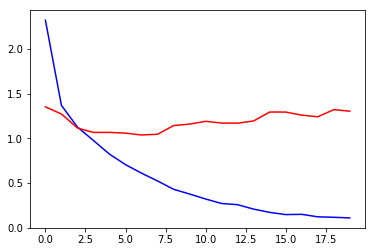

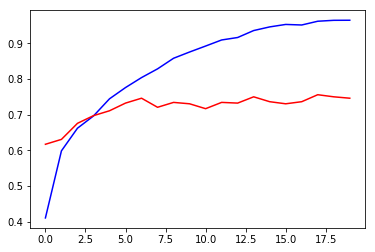

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['acc'], color='b')
plt.plot(hist.history['val_acc'], color='r')
plt.show()

In [21]:
saveModel(model, run_name_acc)

### Predict

In [22]:
df2 = pd.read_csv('.\\input\\sample_submission.csv')
n_test = len(df2)
print(df2.shape)

(10357, 121)


In [23]:
width = 299
x_test = np.zeros((n_test, width, width, 3), dtype=np.uint8)
for i in tqdm(range(n_test)):
    x_test[i] = cv2.resize(cv2.imread('.\\input\\test\\%s.jpg' % df2['id'][i]), (width, width))

100%|███████████████████████████████████| 10357/10357 [00:57<00:00, 181.12it/s]


In [24]:
y_pred = model.predict(x_test, batch_size=128)
print(y_pred.shape)

(10357, 120)


In [25]:
for i in range(0, 120):
    df2.iloc[:,[i+1]] = y_pred[:,i]
if not os.path.exists(output_path):
    os.mkdir(output_path)
pred_file = os.path.join(output_path, 'pred_' + run_name_acc + '.csv')
df2.to_csv(pred_file, index=None)

In [26]:
print(run_name_acc)
print('Done !')

Dog_Breed_Identification_InceptionV3FineTune_20171102_104830_7460
Done !
